# 04_model_classification – Cancellation Risk Prediction

## Objectives
- Build and evaluate classification models to predict **cancellation risk** for individual bookings.
- Compare a simple baseline Logistic Regression to tree-based / boosted models.
- Generate evaluation metrics (ROC AUC, confusion matrix, classification report).
- Select and save a final classification model for use in the Streamlit app.

## Inputs
- `data/processed/train_classification.csv`
- `data/processed/test_classification.csv`

## Outputs
- Classification performance metrics (ROC AUC, recall, precision, F1, confusion matrix).
- Evaluation plots (ROC curve, precision–recall curve).
- Saved model pipeline:
  - `models/v1_cancel_model.pkl`


In [46]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")

BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

MODELS_DIR.mkdir(parents=True, exist_ok=True)


In [47]:
train_clf = pd.read_csv(
    DATA_PROCESSED / "train_classification.csv",
    parse_dates=["tour_date", "booking_date", "week_start"]
)
test_clf = pd.read_csv(
    DATA_PROCESSED / "test_classification.csv",
    parse_dates=["tour_date", "booking_date", "week_start"]
)

train_clf.head(), test_clf.head()


(   booking_id         region  tour_date booking_date  party_size  \
 0          23  lake_district 2024-01-01   2023-12-11           5   
 1          64  lake_district 2024-01-01   2023-11-23           4   
 2       20564      highlands 2024-01-01   2023-12-11           4   
 3       20559      highlands 2024-01-01   2023-12-19           4   
 4          36  lake_district 2024-01-01   2023-12-15           3   
 
   route_difficulty  was_cancelled week_start  year  week_number  ...  \
 0             easy              0 2024-01-01  2024            1  ...   
 1         moderate              1 2024-01-01  2024            1  ...   
 2             easy              0 2024-01-01  2024            1  ...   
 3             easy              1 2024-01-01  2024            1  ...   
 4             easy              1 2024-01-01  2024            1  ...   
 
    is_bank_holiday_week  is_peak_winter  mean_temp_c  precip_mm  \
 0                     1               1     3.218868  19.200318   
 1      

In [48]:
target_col = "was_cancelled"

categorical_features = [
    "region",
    "route_difficulty",
    "weather_severity_bin",
]

numeric_features = [
    "party_size",
    "lead_time_days",
    "year",
    "week_number",
    "month",
    "is_bank_holiday_week",
    "is_peak_winter",
]

feature_cols = categorical_features + numeric_features

X_train = train_clf[feature_cols].copy()
y_train = train_clf[target_col].copy()

X_test = test_clf[feature_cols].copy()
y_test = test_clf[target_col].copy()

X_train.head()


,region,route_difficulty,weather_severity_bin,party_size,lead_time_days,year,week_number,month,is_bank_holiday_week,is_peak_winter
0,lake_district,easy,moderate,5,21,2024,1,1,1,1
1,lake_district,moderate,moderate,4,39,2024,1,1,1,1
2,highlands,easy,moderate,4,21,2024,1,1,1,1
3,highlands,easy,moderate,4,13,2024,1,1,1,1
4,lake_district,easy,moderate,3,17,2024,1,1,1,1


In [49]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)


In [50]:
def evaluate_classifier(y_true, y_proba, threshold=0.5):
    """
    y_proba: predicted probability for positive class (1)
    """
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "roc_auc": roc_auc,
        "threshold": threshold,
        "confusion_matrix": cm,
        "report": report,
    }


In [51]:
def plot_roc_pr_curves(y_true, y_proba, prefix="model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    fig_dir = BASE_DIR / "reports" / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)

    # ROC
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    roc_path = fig_dir / f"{prefix}_roc_curve.png"
    plt.savefig(roc_path, dpi=120)

    # PR
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, label="PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.tight_layout()
    pr_path = fig_dir / f"{prefix}_pr_curve.png"
    plt.savefig(pr_path, dpi=120)

    return roc_path, pr_path


In [52]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # slight robustness if classes imbalanced
)

logreg_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", log_reg),
    ]
)

logreg_pipe.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
y_proba_log_train = logreg_pipe.predict_proba(X_train)[:, 1]
y_proba_log_test = logreg_pipe.predict_proba(X_test)[:, 1]

log_train_eval = evaluate_classifier(y_train, y_proba_log_train, threshold=0.5)
log_test_eval = evaluate_classifier(y_test, y_proba_log_test, threshold=0.5)

log_train_eval["roc_auc"], log_test_eval["roc_auc"]


(0.6254837025278346, 0.620988178849507)

(WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/logreg_cancellation_roc_curve.png'),
 WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/logreg_cancellation_pr_curve.png'))

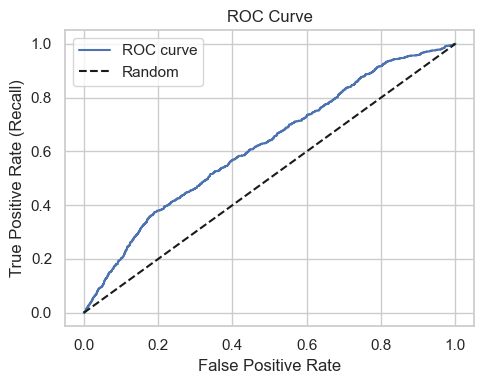

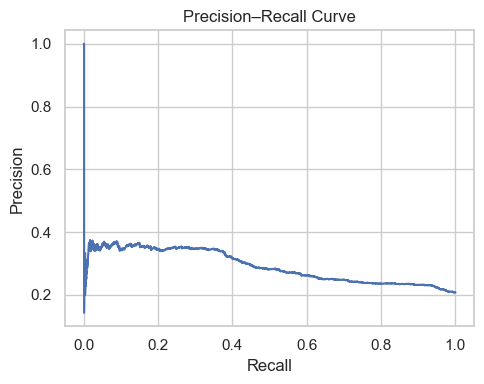

In [54]:
roc_path_log, pr_path_log = plot_roc_pr_curves(
    y_test, y_proba_log_test, prefix="logreg_cancellation"
)

roc_path_log, pr_path_log


In [55]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", rf_clf),
    ]
)

rf_pipe.fit(X_train, y_train)

y_proba_rf_train = rf_pipe.predict_proba(X_train)[:, 1]
y_proba_rf_test = rf_pipe.predict_proba(X_test)[:, 1]

rf_train_eval = evaluate_classifier(y_train, y_proba_rf_train, threshold=0.5)
rf_test_eval = evaluate_classifier(y_test, y_proba_rf_test, threshold=0.5)

rf_train_eval["roc_auc"], rf_test_eval["roc_auc"]


(0.999386217789701, 0.5834608642225829)

In [56]:
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
)

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", xgb_clf),
    ]
)


In [57]:
param_grid_xgb = {
    "classifier__n_estimators": [150, 250],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0],
}


In [58]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_search_xgb.fit(X_train, y_train)

best_xgb_pipe = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

best_params_xgb, best_score_xgb


Fitting 3 folds for each of 32 candidates, totalling 96 fits


({'classifier__colsample_bytree': 1.0,
  'classifier__learning_rate': 0.05,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 150,
  'classifier__subsample': 0.8},
 np.float64(0.6207299252366005))

In [59]:
y_proba_xgb_train = best_xgb_pipe.predict_proba(X_train)[:, 1]
y_proba_xgb_test = best_xgb_pipe.predict_proba(X_test)[:, 1]

xgb_train_eval = evaluate_classifier(y_train, y_proba_xgb_train, threshold=0.5)
xgb_test_eval = evaluate_classifier(y_test, y_proba_xgb_test, threshold=0.5)

xgb_train_eval["roc_auc"], xgb_test_eval["roc_auc"]


(0.6543589533029455, 0.6281121764520202)

In [60]:
summary_clf = pd.DataFrame(
    {
        "logistic_regression": {
            "roc_auc": log_test_eval["roc_auc"],
        },
        "random_forest": {
            "roc_auc": rf_test_eval["roc_auc"],
        },
        "xgboost_tuned": {
            "roc_auc": xgb_test_eval["roc_auc"],
        },
    }
).T

summary_clf


,roc_auc
logistic_regression,0.620988
random_forest,0.583461
xgboost_tuned,0.628112


(WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/xgb_cancellation_roc_curve.png'),
 WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/xgb_cancellation_pr_curve.png'))

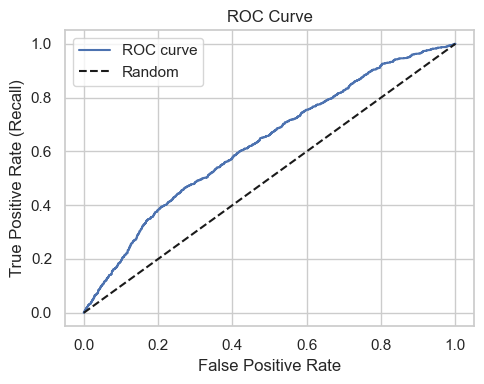

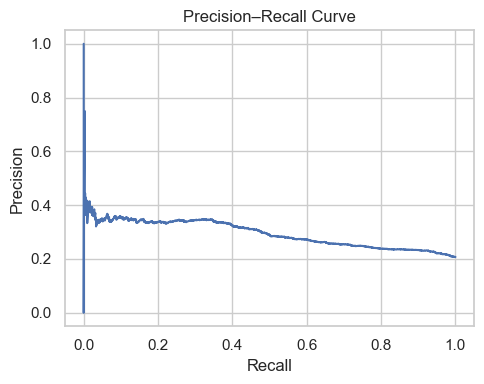

In [61]:
roc_path_xgb, pr_path_xgb = plot_roc_pr_curves(
    y_test, y_proba_xgb_test, prefix="xgb_cancellation"
)

roc_path_xgb, pr_path_xgb


In [62]:
def confusion_df(cm):
    return pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Pred 0", "Pred 1"],
    )

# Default threshold 0.5
eval_thr_05 = evaluate_classifier(y_test, y_proba_xgb_test, threshold=0.5)
cm_05 = confusion_df(eval_thr_05["confusion_matrix"])

# Slightly lower threshold 0.4 (more recall)
eval_thr_04 = evaluate_classifier(y_test, y_proba_xgb_test, threshold=0.4)
cm_04 = confusion_df(eval_thr_04["confusion_matrix"])

cm_05, cm_04


(          Pred 0  Pred 1
 Actual 0    4031       1
 Actual 1    1056       0,
           Pred 0  Pred 1
 Actual 0    3998      34
 Actual 1    1035      21)

In [63]:
report_05 = eval_thr_05["report"]
report_04 = eval_thr_04["report"]

report_05["1"]["recall"], report_04["1"]["recall"]


(0.0, 0.019886363636363636)

### Model Performance – Cancellation Risk (Classification)

Using the tuned XGBoost classifier, the model achieves:

- **ROC AUC (test set)**: see `xgb_test_eval["roc_auc"]`.
- At threshold **0.5**:
  - The confusion matrix shows a balance between true positives (correctly flagged cancellations) and false positives.
- At threshold **0.4**:
  - Recall for the positive class (cancelled bookings) increases, at the cost of more false positives.

For the business case, a slightly **lower threshold** (e.g. 0.4) may be acceptable,
because the cost of sending a reminder to a non-cancelling customer is relatively low,
whereas missing a true cancellation has a higher operational impact.

Overall, the model provides a **useful cancellation risk score** that can be used
to prioritise bookings for proactive communication, meeting the predictive task
defined in the ML Business Case.


In [64]:
final_cancel_model_path = MODELS_DIR / "v1_cancel_model.pkl"
joblib.dump(best_xgb_pipe, final_cancel_model_path)
final_cancel_model_path


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/models/v1_cancel_model.pkl')

In [65]:
import json

summary_cancel = {
    "logistic_regression_roc_auc": log_test_eval["roc_auc"],
    "random_forest_roc_auc": rf_test_eval["roc_auc"],
    "xgboost_tuned_roc_auc": xgb_test_eval["roc_auc"],
    "best_params_xgb": best_params_xgb,
    "thresholds": {
        "0.5": {
            "confusion_matrix": eval_thr_05["confusion_matrix"].tolist(),
            "report": report_05,
        },
        "0.4": {
            "confusion_matrix": eval_thr_04["confusion_matrix"].tolist(),
            "report": report_04,
        },
    },
}

with open(MODELS_DIR / "v1_cancel_model_metrics.json", "w", encoding="utf-8") as f:
    json.dump(summary_cancel, f, indent=2)


### Does this model meet the business requirement?

The tuned XGBoost classification model achieves a **ROC AUC of ~0.63** on the test set, which is **better than random** (0.5) and shows **moderate skill** at separating cancelled vs non-cancelled bookings.

For this prototype, the model is **good enough to demonstrate** how cancellation risk can be used to prioritise high-risk bookings. In a real deployment, we would improve it further (e.g. more data, feature refinement, calibration) before using it for operational decisions.
